Задача проекта оптимизировать производственные расходы для металлургического комбинат ООО «Так закаляем сталь» в цедях уменьшения потребление электроэнергии на этапе обработки стали.  
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

# Импорт библиотек

In [1]:
!pip install shap -q

In [2]:
!pip install optuna -q

In [3]:
!pip install catboost -q

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.plotting import scatter_matrix

# импорт 2 части выпускного проекта
import warnings
import plotly.express as px
import optuna
import shap

import scipy.stats as stats
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from catboost import CatBoostRegressor
import catboost

warnings.filterwarnings('ignore')

# Импорт данных

In [5]:
try:
    #выгрузка данных с локального компьютера
    data_arc_new = pd.read_csv('/Users/samolinovkonstantin/Desktop/Yandex/sprint/final_sprint/data_arc_new.csv')
    data_bulk_new = pd.read_csv('/Users/samolinovkonstantin/Desktop/Yandex/sprint/final_sprint/data_bulk_new.csv')
    data_bulk_time_new = pd.read_csv('/Users/samolinovkonstantin/Desktop/Yandex/sprint/final_sprint/data_bulk_time_new.csv')
    data_gas_new = pd.read_csv('/Users/samolinovkonstantin/Desktop/Yandex/sprint/final_sprint/data_gas_new.csv')
    data_temp_new = pd.read_csv('/Users/samolinovkonstantin/Desktop/Yandex/sprint/final_sprint/data_temp_new.csv')
    data_wire_new = pd.read_csv('/Users/samolinovkonstantin/Desktop/Yandex/sprint/final_sprint/data_wire_new.csv')
    data_wire_time_new = pd.read_csv('/Users/samolinovkonstantin/Desktop/Yandex/sprint/final_sprint/data_wire_time_new.csv')
except:
    #выгрузка данных с сервера
    data_arc_new = pd.read_csv('/datasets/data_arc_new.csv')
    data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
    data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp_new = pd.read_csv('/datasets/data_temp_new.csv')
    data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv')

# Первичный анализ данных

## Анализ значений

In [6]:
#функция для первичного анализа
def data_eda(data):
    display(data.sample(10)) #вывод 10 случайных строк
    print('********************************************************************************************')
    print('Общая информация по таблице')
    print(data.info())
    print('****************************************************')
    print('описание значений')
    print(data.describe())
    print('****************************************************')
    print('Количество дублирующих значений')
    print(len(data[data.duplicated()]))
    print('****************************************************')
    print('Количество пропущенных значений в таблице в %')
    print(data.isna().mean()*100)
    print('************************************************************************')
    scatter_matrix(data)
    plt.show()

In [7]:
#функция для boxplot
def boxplot_eda(data):
    for column in data:
        boxplot = plt.boxplot(data[column].values)
        outliers = list(boxplot["fliers"][0].get_data()[1])
        data_outliers = data[data[column].isin(outliers)]
        print(f'           Количество аномалий в столбце {column}: {len(data_outliers)} значений|{len(data_outliers)/len(data[column])*100:.3f}%')
        plt.title(f'Boxlot для столбца {column}')
        plt.ylabel('Величина значений')
        plt.show()

In [8]:
def disp(data):
    for column in data:
        data[column].hist()
        plt.title(f'Распределение для значений столбца {column}')
        plt.xlabel('значение')
        plt.ylabel('количество')
        plt.show()

### Анализ данных "data_arc_new"

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
12490  2715  2019-08-18 12:00:54  2019-08-18 12:03:10           1.198254   
10059  2180  2019-07-30 05:06:16  2019-07-30 05:08:20           0.613236   
297      64  2019-05-05 22:56:20  2019-05-05 22:58:55           0.829865   
8994   1950  2019-07-21 01:34:16  2019-07-21 01:41:44           0.509273   
8874   1926  2019-07-19 16:53:39  2019-07-19 16:55:17           0.772848   
8904   1932  2019-07-19 22:05:22  2019-07-19 22:06:06           0.446134   
10971  2386  2019-08-06 14:11:47  2019-08-06 14:14:42           1.185984   
10653  2316  2019-08-03 20:27:22  2019-08-03 20:29:10           0.760413   
6420   1398  2019-06-25 03:19:09  2019-06-25 03:20:26           0.836145   
12520  2721  2019-08-18 15:33:43  2019-08-18 15:34:50           1.129755   

       Реактивная мощность  
12490             0.837111  
10059             0.474738  
297               0.646825  
8994              0.346724  
8874              0.521295  
8904              0.344473  
10971             0.890860  
10653             0.504782  
6420              0.644099  
12520             0.717042

********************************************************************************************
Общая информация по таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
****************************************************
описание значений
                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.662752             0.438986
std      934.571502           0.258885             5.873485
min        1.000000           0.22

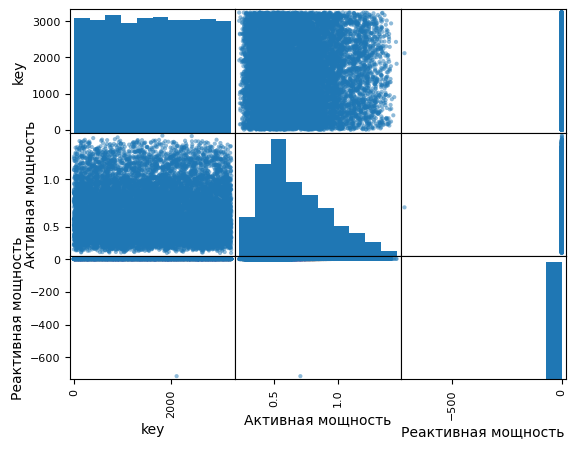

In [9]:
data_eda(data_arc_new)

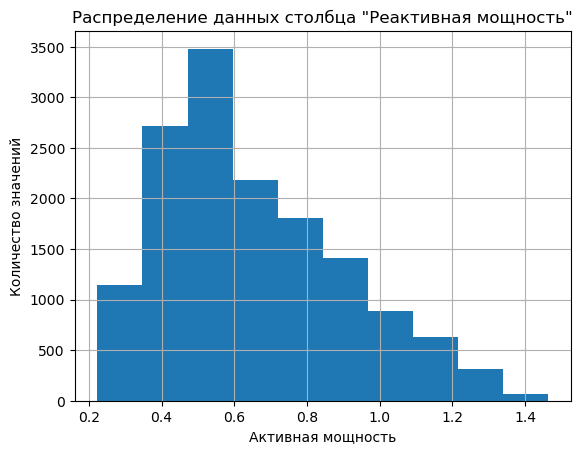

In [10]:
%matplotlib inline
##так как столбец "Реативная мощность имеет выбросы, построим график столбца отдельно ограничив значения"
tmp = (data_arc_new.loc[(data_arc_new['Реактивная мощность'] >= -1)&\
                        (data_arc_new['Реактивная мощность'] <= 1), 'Активная мощность'])
tmp.hist()
plt.title('Распределение данных столбца "Реактивная мощность"')
plt.ylabel('Количество значений')
plt.xlabel('Активная мощность')
plt.show()

**В таблице "data_arc_new":**
* отсутвуют пропущенные значения
* Столбец "Активная мощность" имеет нормальное распределение со смещением влево
* Столбец "Реактивная мощность" имеет нормальное распределение со смещением влево

### Анализ данных "data_bulk_new"

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
1153  1201     NaN     NaN   240.0    64.0     NaN     NaN     NaN     NaN   
1055  1101     NaN     NaN   354.0     NaN     NaN   115.0     NaN     NaN   
1879  1942     NaN     NaN   122.0     NaN     NaN     NaN     NaN     NaN   
2547  2645     NaN     NaN    62.0    84.0     NaN     NaN     NaN     NaN   
1403  1457     NaN     NaN   104.0     NaN     NaN     NaN     NaN     NaN   
1585  1644     NaN     NaN    21.0     NaN     NaN     NaN     NaN     NaN   
2379  2467     NaN     NaN    45.0     NaN     NaN     NaN     NaN     NaN   
1056  1102     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
330    354     NaN     NaN     NaN     NaN     NaN   151.0     NaN     NaN   
2415  2507     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

      Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
1153     NaN      NaN      NaN    206.0      NaN    147.0    102.0  
1055     NaN      NaN      NaN    206.0      NaN    141.0    105.0  
1879     NaN      NaN      NaN    360.0      NaN    160.0    212.0  
2547     NaN      NaN      NaN    238.0      NaN    132.0    224.0  
1403     NaN      NaN      NaN      NaN      NaN      NaN      NaN  
1585     NaN      NaN      NaN    203.0      NaN    102.0    104.0  
2379     NaN      NaN      NaN      NaN      NaN    193.0      NaN  
1056     NaN      NaN      NaN    311.0      NaN    154.0      NaN  
330      NaN      NaN     25.0    207.0      NaN    247.0    102.0  
2415     NaN      NaN      NaN      NaN      NaN    250.0    156.0

********************************************************************************************
Общая информация по таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
******************************

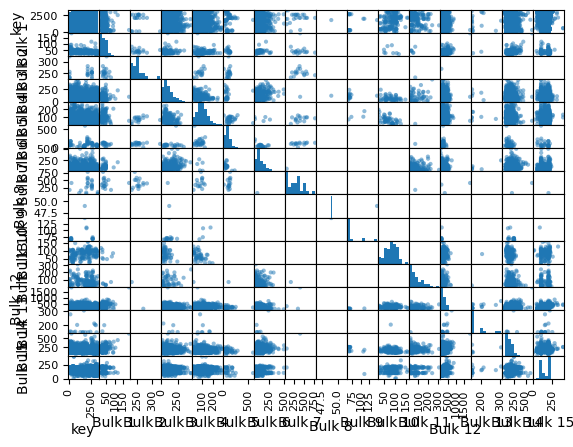

In [11]:
data_eda(data_bulk_new)

**В таблице "data_bulk_new":**
* столбцы `Bulk 1 - bulk 11`, `Bulk 13` имеют свыше 50% пропусков, в отдельных столбцах потеряно свыше 94% данных
* строить прогноз по предостваленным данным в этой таблице не целесообразно

#### замена пустых значений на 0

Предположим что пропущенные значения обозначают "0" и заменим во всей таблице.

In [12]:
data_bulk_new_0 = data_bulk_new.fillna(0)

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
2881  2987     0.0     0.0   106.0     0.0     0.0     0.0     0.0     0.0   
886    922     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2562  2660     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
756    790     0.0     0.0   256.0     0.0     0.0    40.0     0.0     0.0   
305    324     0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0   
1397  1451     0.0     0.0     0.0   125.0     0.0     0.0     0.0     0.0   
2372  2459     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
66      76     0.0     0.0     0.0    77.0     0.0     0.0     0.0     0.0   
2799  2905    44.0     0.0   144.0     0.0     0.0     0.0     0.0     0.0   
1988  2059     0.0     0.0    85.0     0.0     0.0     0.0     0.0     0.0   

      Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
2881     0.0      0.0      0.0    208.0      0.0     84.0    104.0  
886      0.0      0.0      0.0    257.0      0.0    153.0    203.0  
2562     0.0      0.0      0.0    104.0      0.0    120.0    206.0  
756      0.0      0.0      0.0    307.0      0.0    216.0    158.0  
305      0.0      0.0      0.0    155.0      0.0    100.0    203.0  
1397     0.0      0.0      0.0    411.0      0.0    224.0    206.0  
2372     0.0      0.0     20.0    157.0      0.0    146.0    106.0  
66       0.0     56.0      0.0      0.0      0.0      0.0      0.0  
2799     0.0      0.0      0.0    570.0      0.0    204.0      0.0  
1988     0.0      0.0      0.0    516.0      0.0    205.0    106.0

********************************************************************************************
Общая информация по таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 8   3129 non-null   float64
 9   Bulk 9   3129 non-null   float64
 10  Bulk 10  3129 non-null   float64
 11  Bulk 11  3129 non-null   float64
 12  Bulk 12  3129 non-null   float64
 13  Bulk 13  3129 non-null   float64
 14  Bulk 14  3129 non-null   float64
 15  Bulk 15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
******************************

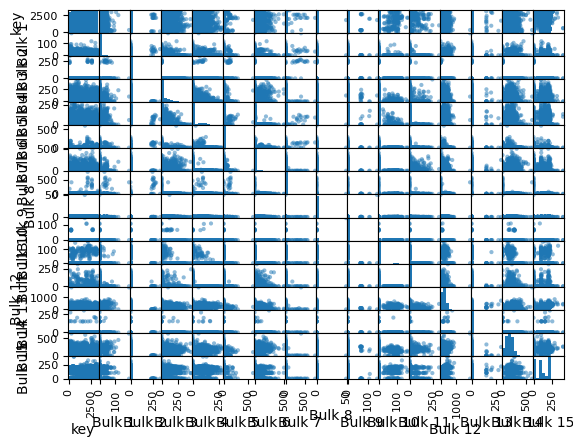

In [13]:
data_eda(data_bulk_new_0)

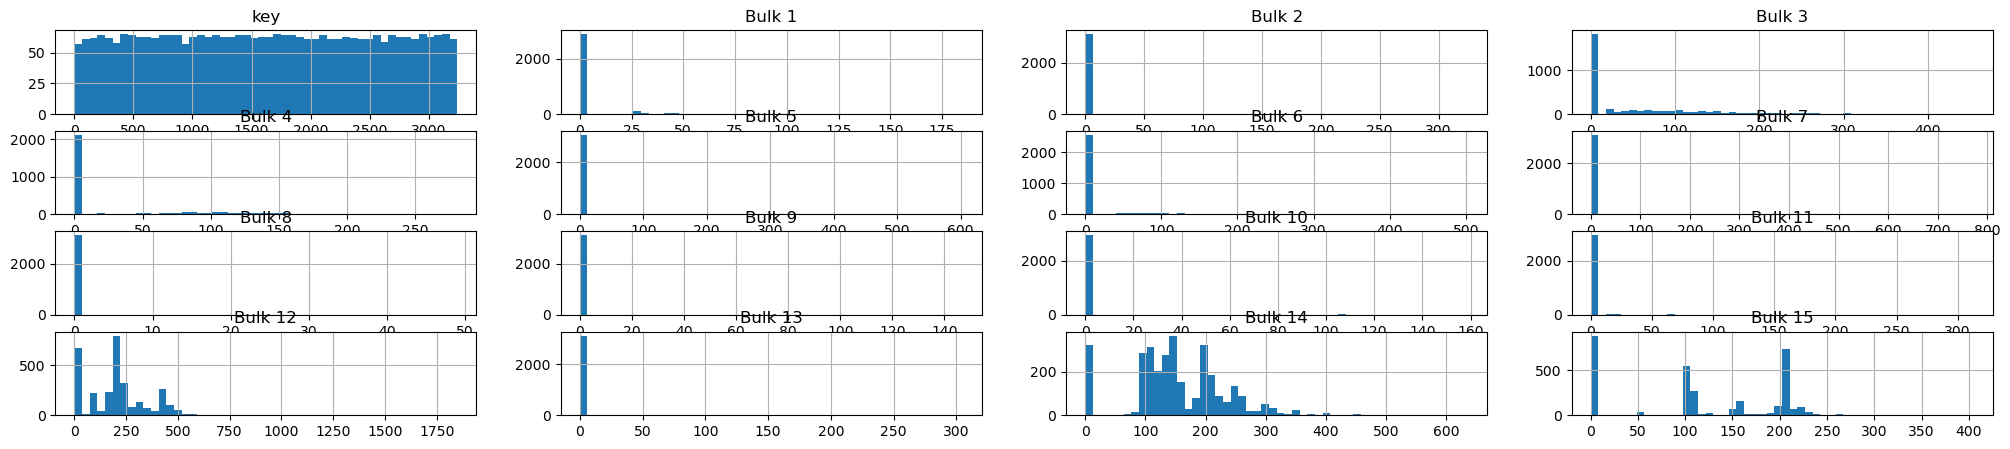

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(25, 5))
axe = axes.ravel()
for i, c in enumerate(data_bulk_new_0.columns):
    axe[i].set_title(data_bulk_new_0.columns[i])
    data_bulk_new_0[c].hist(ax=axe[i], bins=50)

Замена пропущенных значений на 0 показывает, что данные в столбцах
- bulk 12
- bulk 14
- bulk 15  

имеют несколько пиков

### Анализ данных "data_bulk_time_new"

key Bulk 1 Bulk 2               Bulk 3               Bulk 4 Bulk 5  \
545    574    NaN    NaN                  NaN                  NaN    NaN   
2761  2865    NaN    NaN                  NaN                  NaN    NaN   
2393  2484    NaN    NaN                  NaN  2019-08-09 23:43:05    NaN   
1154  1202    NaN    NaN                  NaN  2019-06-18 00:39:39    NaN   
1176  1225    NaN    NaN                  NaN                  NaN    NaN   
730    763    NaN    NaN                  NaN  2019-06-02 10:21:50    NaN   
1011  1056    NaN    NaN                  NaN  2019-06-13 01:21:48    NaN   
3074  3184    NaN    NaN  2019-09-04 18:17:17                  NaN    NaN   
1338  1390    NaN    NaN  2019-06-24 21:00:07                  NaN    NaN   
403    429    NaN    NaN                  NaN  2019-05-19 21:20:34    NaN   

     Bulk 6 Bulk 7 Bulk 8 Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13  \
545     NaN    NaN    NaN    NaN     NaN     NaN  2019-05-25 07:34:56     NaN   
2761    NaN    NaN    NaN    NaN     NaN     NaN                  NaN     NaN   
2393    NaN    NaN    NaN    NaN     NaN     NaN  2019-08-09 23:43:05     NaN   
1154    NaN    NaN    NaN    NaN     NaN     NaN  2019-06-18 00:36:10     NaN   
1176    NaN    NaN    NaN    NaN     NaN     NaN  2019-06-18 18:17:18     NaN   
730     NaN    NaN    NaN    NaN     NaN     NaN                  NaN     NaN   
1011    NaN    NaN    NaN    NaN     NaN     NaN                  NaN     NaN   
3074    NaN    NaN    NaN    NaN     NaN     NaN  2019-09-04 18:51:31     NaN   
1338    NaN    NaN    NaN    NaN     NaN     NaN  2019-06-24 21:12:06     NaN   
403     NaN    NaN    NaN    NaN     NaN     NaN  2019-05-19 21:06:38     NaN   

                  Bulk 14              Bulk 15  
545   2019-05-25 07:20:31  2019-05-25 07:17:18  
2761  2019-08-24 05:40:53                  NaN  
2393  2019-08-09 23:43:05  2019-08-09 23:43:05  
1154  2019-06-18 00:27:29  2019-06-18 00:17:22  
1176  2019-06-18 18:14:34  2019-06-18 18:09:07  
730                   NaN                  NaN  
1011                  NaN                  NaN  
3074  2019-09-04 18:44:29  2019-09-04 18:40:36  
1338  2019-06-24 21:17:14  2019-06-24 21:12:06  
403   2019-05-19 21:00:28  2019-05-19 20:53:01

********************************************************************************************
Общая информация по таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None
************************************************

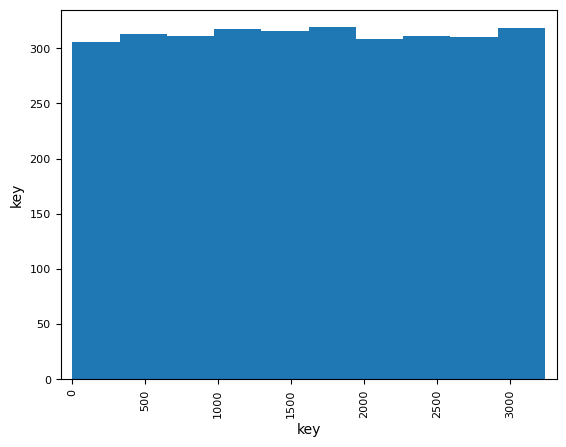

In [15]:
data_eda(data_bulk_time_new)

**В таблице "data_bulk_time_new":**
* столбцы `Bulk 1 - bulk 11`, `Bulk 13` имеют свыше 50% пропусков, в отдельных столбцах потеряно 94% данных
* строить прогноз по предостваленным данным в этой таблице не целесообразно
* можно предположить, что отсутствующие значения означают что в данный день не было конкретной примеси в процесси производства

### Анализ данных "data_gas_new"

key      Газ 1
2771  2774  10.079005
680    683   1.002708
2415  2418   6.370933
2350  2353  11.470960
1005  1008  12.651844
1945  1948  10.406837
2339  2342  14.132198
134    135   7.017192
2551  2554  19.809298
214    216   6.871800

********************************************************************************************
Общая информация по таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
****************************************************
описание значений
               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040
****************************************************
Количество дублирующих значений
0
****************************************************
Количество пропущенных значений в таблице в %
key      0.0
Газ 1    0.

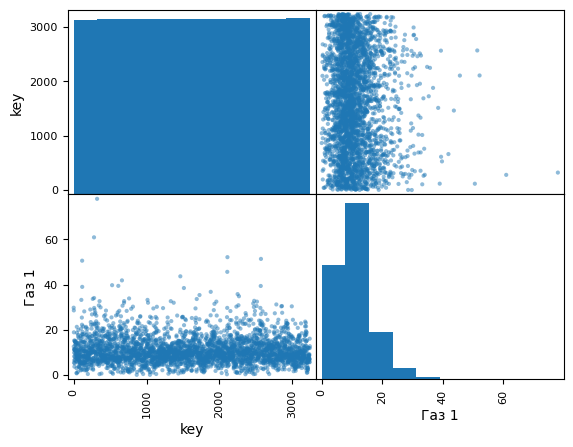

In [16]:
data_eda(data_gas_new)

**В таблице "data_gas_new":**
* в данных отсутствуют пропуски
* в данных содержится только один столбец с информацией "Газ 1", а так-же столбец "key" для возможности сопряжения информации между таблицами
* Данные столбца "Газ 1" имеют нормальное распределение со смещением влево

### Анализ данных "data_temp_new"

key         Время замера  Температура
1238    221  2019-05-11 22:06:00       1589.0
12045  2148  2019-07-29 03:42:39       1579.0
8541   1525  2019-06-29 20:21:08       1668.0
845     149  2019-05-09 09:05:30       1618.0
4505    805  2019-06-03 22:11:57       1578.0
15926  2850  2019-08-23 14:40:25       1636.0
427      76  2019-05-06 07:51:40       1592.0
11215  2001  2019-07-23 13:40:51       1629.0
13363  2391  2019-08-06 17:30:31       1623.0
10266  1835  2019-07-10 14:39:40       1592.0

********************************************************************************************
Общая информация по таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None
****************************************************
описание значений
                key   Температура
count  18092.000000  14665.000000
mean    1616.460977   1590.722741
std      934.641385     20.394381
min        1.000000   1191.000000
25%      807.750000   1580.000000
50%     1618.000000   1590.000000
75%     2429.000000   1599.000000
max     3241.000000   1705.000000
****************************************************
Количество дублирующих значений
0
***********************

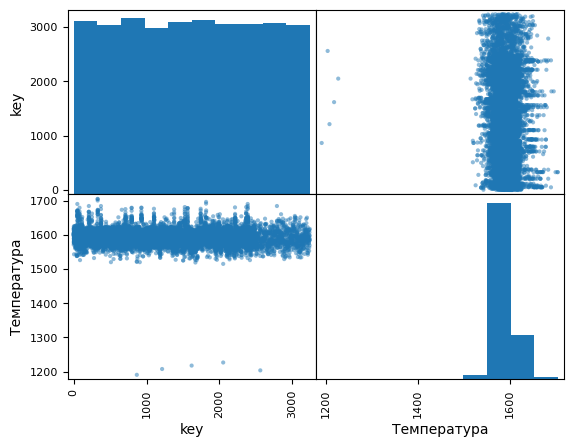

In [17]:
data_eda(data_temp_new)

**В таблице "data_temp_new":**
* в таблице содержится информация по времени и замера и температуре в момент замера
* в таблице отсутствует 19% данных 
* Значения столбца "Температура" имеет нормальное распределение со смещением вправо. Смещение возможно обусловлено выбросами значений

### Анализ данных "data_wire_new"

key      Wire 1      Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  \
248    271  140.169114   75.129600     NaN     NaN     NaN     NaN     NaN   
332    359  114.191993         NaN     NaN     NaN     NaN     NaN     NaN   
3037  3196  102.123840         NaN     NaN     NaN     NaN     NaN     NaN   
2117  2225   46.038719         NaN     NaN     NaN     NaN     NaN     NaN   
1000  1060  166.701602         NaN     NaN     NaN     NaN     NaN     NaN   
2200  2311  101.075520   41.258881     NaN     NaN     NaN     NaN     NaN   
54      63   47.960640   72.188484     NaN     NaN     NaN     NaN     NaN   
1254  1323  145.173600         NaN     NaN     NaN     NaN     NaN     NaN   
1114  1181         NaN  100.101036     NaN     NaN     NaN     NaN     NaN   
2770  2923   52.110241   19.121441     NaN     NaN     NaN     NaN     NaN   

      Wire 8  Wire 9  
248      NaN     NaN  
332      NaN     NaN  
3037     NaN     NaN  
2117     NaN     NaN  
1000     NaN     NaN  
2200     NaN     NaN  
54       NaN     NaN  
1254     NaN     NaN  
1114     NaN     NaN  
2770     NaN     NaN

********************************************************************************************
Общая информация по таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
****************************************************
описание значений
               key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.57

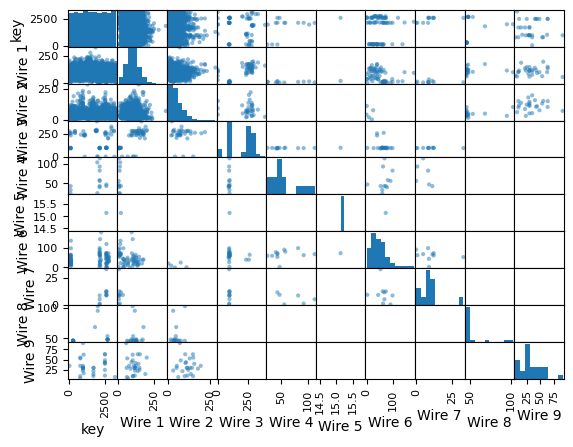

In [18]:
data_eda(data_wire_new)

**В таблице "data_wire_new":**
* отсутвуют данные во всех столбцах, в столбце "wire 2" отсутствует 65%, в остальных отсутствует ~99% данных
* строить прогноз по предостваленным данным в этой таблице не целесообразно

#### Анализ data_wire_new с заменой пропущенных значений на 0

In [19]:
data_wire_new_0 = data_wire_new.fillna(0)

key      Wire 1      Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  \
877    937  142.084793    0.000000     0.0     0.0     0.0     0.0     0.0   
279    302   58.181759   21.170240     0.0     0.0     0.0     0.0     0.0   
694    737  183.268787    0.000000     0.0     0.0     0.0     0.0     0.0   
985   1045   55.130398    0.000000     0.0     0.0     0.0     0.0     0.0   
1921  2016   93.125755    0.000000     0.0     0.0     0.0     0.0     0.0   
2925  3084  106.098724    0.000000     0.0     0.0     0.0     0.0     0.0   
2414  2541   45.995041  120.157432     0.0     0.0     0.0     0.0     0.0   
272    295  110.160957    0.000000     0.0     0.0     0.0     0.0     0.0   
1085  1152  103.053604    0.000000     0.0     0.0     0.0     0.0     0.0   
528    563  140.166000    0.000000     0.0     0.0     0.0     0.0     0.0   

      Wire 8  Wire 9  
877      0.0     0.0  
279      0.0     0.0  
694      0.0     0.0  
985      0.0     0.0  
1921     0.0     0.0  
2925     0.0     0.0  
2414     0.0     0.0  
272      0.0     0.0  
1085     0.0     0.0  
528      0.0     0.0

********************************************************************************************
Общая информация по таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
****************************************************
описание значений
               key       Wire 1       Wire 2       Wire 3       Wire 4  \
count  3081.000000  3081.000000  3081.000000  3081.000000  3081.000000   
mean   1623.426485   100.044411    17.712733     3.8

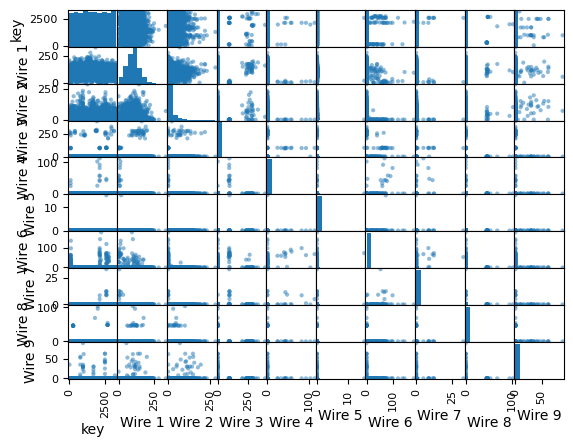

In [20]:
data_eda(data_wire_new_0)

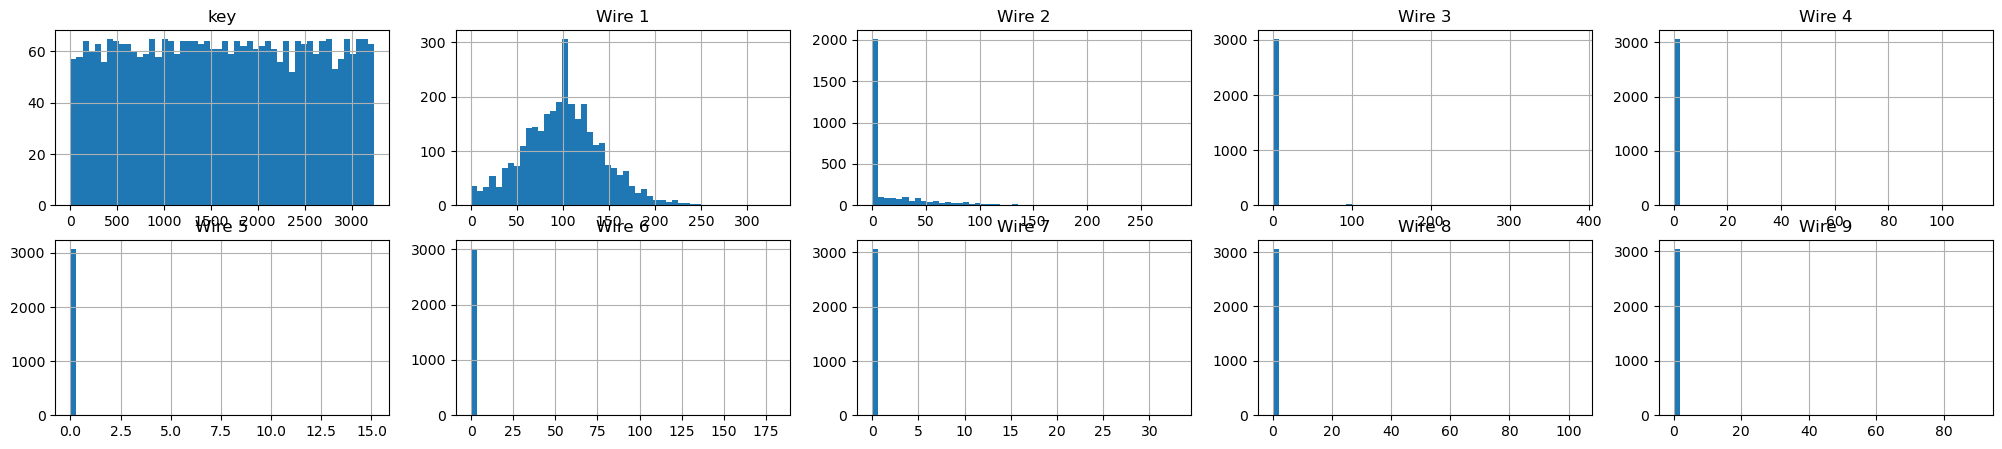

In [21]:
fig, axes = plt.subplots(2, 5, figsize=(25, 5))
axe = axes.ravel()
for i, c in enumerate(data_wire_new_0.columns):
    axe[i].set_title(data_wire_new_0.columns[i])
    data_wire_new_0[c].hist(ax=axe[i], bins=50)

Замена пропущенных значений на 0 показывает, что данные в столбцe `wire 1` имеет нормальное распределение, остальные столбцы нулевые.

### Анализ данных "data_wire_time_new"

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5  \
2793  2946  2019-08-27 10:59:46                  NaN    NaN    NaN    NaN   
2672  2811  2019-08-22 06:36:17                  NaN    NaN    NaN    NaN   
1790  1880  2019-07-12 07:31:45                  NaN    NaN    NaN    NaN   
2425  2552  2019-08-12 09:43:30                  NaN    NaN    NaN    NaN   
1375  1447  2019-06-26 18:59:36                  NaN    NaN    NaN    NaN   
1512  1591  2019-07-02 04:15:12                  NaN    NaN    NaN    NaN   
2348  2474  2019-08-09 16:12:37  2019-08-09 16:06:18    NaN    NaN    NaN   
1379  1451  2019-06-26 23:59:54                  NaN    NaN    NaN    NaN   
2616  2750  2019-08-19 22:43:16                  NaN    NaN    NaN    NaN   
2981  3140  2019-09-03 03:55:24                  NaN    NaN    NaN    NaN   

     Wire 6 Wire 7 Wire 8 Wire 9  
2793    NaN    NaN    NaN    NaN  
2672    NaN    NaN    NaN    NaN  
1790    NaN    NaN    NaN    NaN  
2425    NaN    NaN    NaN    NaN  
1375    NaN    NaN    NaN    NaN  
1512    NaN    NaN    NaN    NaN  
2348    NaN    NaN    NaN    NaN  
1379    NaN    NaN    NaN    NaN  
2616    NaN    NaN    NaN    NaN  
2981    NaN    NaN    NaN    NaN

********************************************************************************************
Общая информация по таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None
****************************************************
описание значений
               key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000
*****************************************

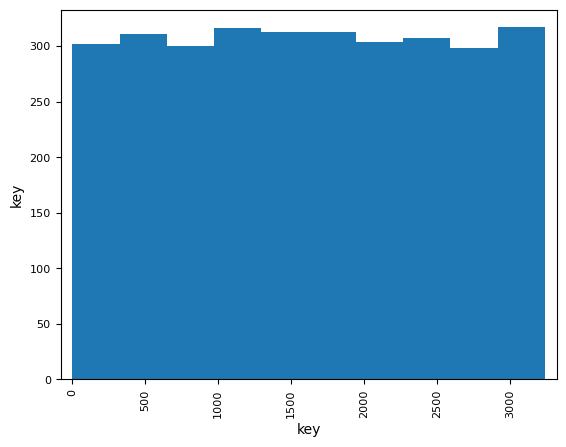

In [22]:
data_eda(data_wire_time_new)

**В таблице "data_wire_time_new":**
* столбцы `Bulk 1 - bulk 11`, `Bulk 13` имеют свыше 50% пропусков, в отдельных столбцах потеряно 94% данных
* строить прогноз по предостваленным данным в этой таблице не целесообразно

## Анализ выбросов

Из п. 3.7. на данный момент можно в работу взять только таблицы:
* data_arc_new
* data_gas_new
* data_temp_new

В остальных данных много пропусков, которые невозможно заменить искуственно.

### Boxplot для data_arc_new

           Количество аномалий в столбце Активная мощность: 72 значений|0.484%


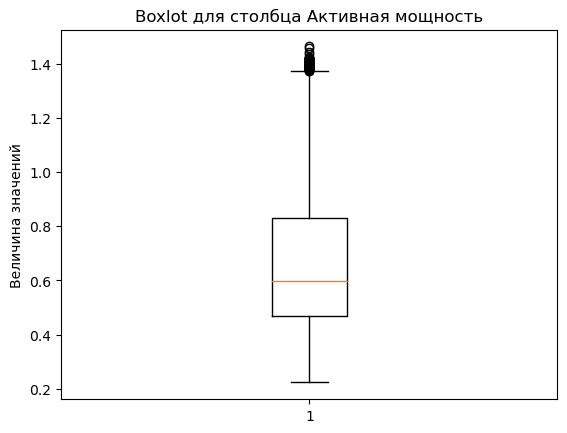

           Количество аномалий в столбце Реактивная мощность: 199 значений|1.338%


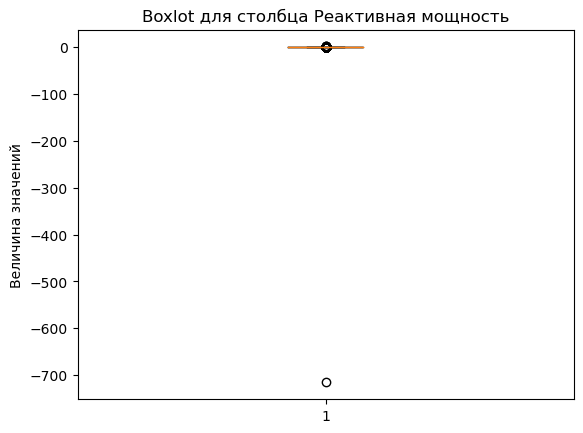

In [23]:
boxplot_eda(data_arc_new[['Активная мощность', 'Реактивная мощность']])

Из-за 1 выброса в столбце "Реактивная мощность" трудно проанилизировать информацию для остальных данных. Исключим его и построим график еще раз

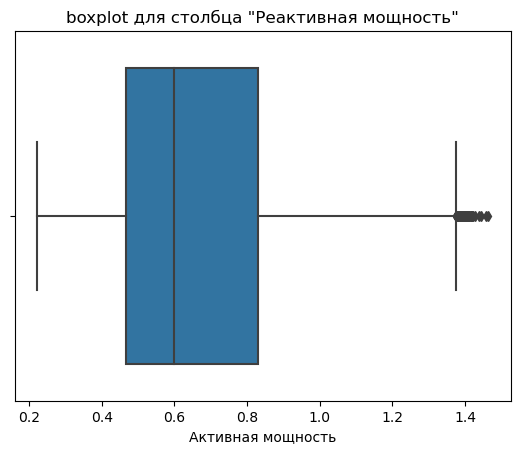

In [24]:
%matplotlib inline
##так как столбец "Реативная мощность имеет выбросы, построим график столбца отдельно ограничив значения"
tmp = (data_arc_new.loc[(data_arc_new['Реактивная мощность'] >= -5)&\
                        (data_arc_new['Реактивная мощность'] <= 5), 'Активная мощность'])
sns.boxplot(data=data_arc_new, x=tmp)
plt.title('boxplot для столбца "Реактивная мощность"')
plt.show()

### Boxplot для data_gas_new

           Количество аномалий в столбце Газ 1: 126 значений|3.890%


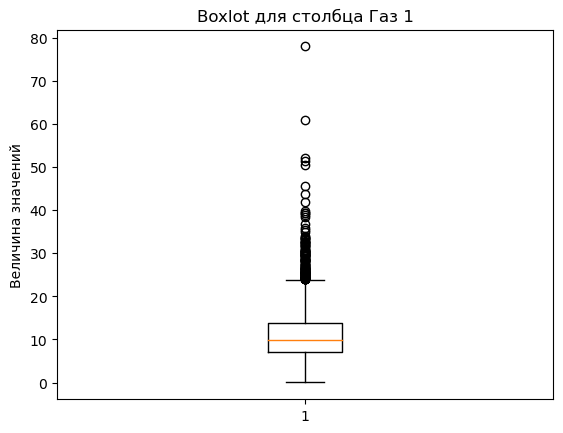

In [25]:
boxplot_eda(data_gas_new[['Газ 1']])

### Boxplot для data_temp_new

           Количество аномалий в столбце Температура: 835 значений|5.694%


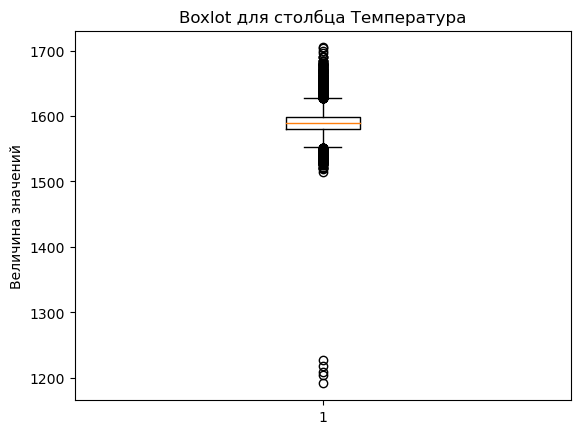

In [26]:
boxplot_eda(data_temp_new[['Температура']].dropna()) #plt.boxplot не видит здесь выбросов

## Выводы по результатам EDA

В данных присутствуют большое количество выбросов, таблицы: 
* data_bulk_new
* data_bulk_time_new
* data_wire_new
* data_wire_time_new  

**непригодны** для анализа из-за пропусков в 90% столбцов по 90% и выше пропусков в строках.

Необходимо проверить корретность выгрузки с базы данных, а также проверить корректность автоматизированного сбора информации с производственного оборудования.

Не смотря на наличие ключей между таблицами, восстановление данных на основе оставшихся данных **не является** возможным.

В таблицах содержатся выбросы:
* data_arc_new - 72 выброса (0.484%) в столбце "Активная мощность" и 199 выбросов(1.338%) в столбце "Реактивная мощность"
* data_gas_new - 126 выбросов (3.89%) в столбце "Газ 1"
* data_temp_new - 835 значений (5.67)% в столбце "Температура"

Количество выбросов не является критичным, но столбец "Температура" в данных `data_temp_new` также содержит 19% отсутствует. 

Распределение в существующих данных в таблице
* data_arc_new 
    * Активная мощность: имеет нормальное распределение со смещением влево
    * Реактивная мощность: имеет нормальное распределение со смещением влево
* data_gas_new 
    * Газ 1: Имеет узкое нормальное распределение со смещением влево, после обработки данных, распределение может стать логарифмическим
* data_temp_new 
    * Температура: имеет очень узкое нормальное распределение

# Дальнейшие действия

1. Создать баг репорта по сбору данных, так как большие потери данных в таблицах
* data_bulk_new
* data_bulk_time_new
* data_wire_new
* data_wire_time_new  

2. Запросить технологический процесс от Главного технолого (Зам. генерального директора по производству), для детального понимания и детализации процесса. Технологическая документация, в обязательном порядке, содержит информацию о количестве подавамых примесей, тока, что позволит корретно провести предобработку данных.  
*Условно, если мы увидим в тех. процессе значение подачи газа не более N, но в собранных данных подача газа превышает это значение, будет означать необходимость доп проверок, так как либо показания некорретно собираются, либо некорретный тех процесс, либо нарушение производственного цикла*

3. Провести предобработку данных, исключить пропуски (где возможно), определить порядок действия с выбросами, исключить некорректные данные.

4. Отобрать 2 модели для линейной регрессии для прогнозирования целевого значения, сделать несколько итераций простой нейронной сети, обучить модели на учебных данных и выбрать одну модель с наилучими показателями.

5. Применить лучшую модель из п.4 на тестовой выборке.

6. Запросить данные по затраченной электро энергии за предыдщий период, перевести в рубли.

7. Перевести в рубли затраченную энергию в предсказываемой модели.

8. Сформировать выводы работы с указанием количества экономии в рублях для предприятия (как обоснование полезности затраченных денег на внедрение систем машинного обучения)

# Ответ на дополнительный вопрос "как прогнозная модель по температуре поможет в энергосбережении"

Объясню свое мнение на примере:  
Для формирования мартенситной структуры стали из углеродитстой стали ($Fe_3C$) необходимо работать со сталью при температура от 800 до 900 градусов. Если мы сможем оптимизировать процесс выпуска стали при меньшей температуре без увеличения объема брака - нам понадобится меньшее количество энергии на поддержание меньшей температуры

# Предобработка данных

## Корректировка типов данных

### Корректировка временных значений

In [27]:
data_arc_new['Начало нагрева дугой'] = pd.to_datetime(data_arc_new['Начало нагрева дугой'])
data_arc_new['Конец нагрева дугой'] = pd.to_datetime(data_arc_new['Конец нагрева дугой'])

In [28]:
data_temp_new['Время замера'] = pd.to_datetime(data_temp_new['Время замера'])

### Обработка данных

#### Замена пропущенных значений

На этапе исследования данных были выявлено, что пропущенные значения в таблицах:  
- data_bulk_new
- data_wire_new

означало, что примесей не добавлялось, на основании чего пропущенные значения будут заменены на 0

In [29]:
data_bulk_new = data_bulk_new.fillna(0)
data_wire_new = data_wire_new.fillna(0)

#### Таблица data_temp_new

При обработки данных столбца `data_temp_new` необходимо будет сделать следующие шаги:
- Исключить все пропущенные значения
    - заменить пропущенные значения на заглушку отрицательной величины (нампример -9999)
    - исключить все партии (key), финальные замерых которых содержат значения заглушки
    - исчключить партии (key), которые содержат темперутуру менее 1390 градусов (по Тех. процессу минимальная величина составляет 1400 градусов, но любое оборудование имеет погрешность и допуски)
- Оставить только последние замеры температуры партии (key)
- Исключить столбец "Время замера", так как у нас не работа с временными рядами

In [30]:
data_temp_new.head(27)

key        Время замера  Температура
0     1 2019-05-03 11:02:04       1571.0
1     1 2019-05-03 11:07:18       1604.0
2     1 2019-05-03 11:11:34       1618.0
3     1 2019-05-03 11:18:04       1601.0
4     1 2019-05-03 11:25:59       1606.0
5     1 2019-05-03 11:30:38       1613.0
6     2 2019-05-03 11:34:04       1581.0
7     2 2019-05-03 11:38:40       1577.0
8     2 2019-05-03 11:46:09       1589.0
9     2 2019-05-03 11:49:38       1604.0
10    2 2019-05-03 11:55:09       1602.0
11    3 2019-05-03 12:06:44       1596.0
12    3 2019-05-03 12:13:42       1597.0
13    3 2019-05-03 12:18:46       1598.0
14    3 2019-05-03 12:25:33       1599.0
15    3 2019-05-03 12:31:04       1600.0
16    3 2019-05-03 12:35:57       1599.0
17    4 2019-05-03 12:39:27       1601.0
18    4 2019-05-03 12:44:37       1623.0
19    4 2019-05-03 12:48:04       1618.0
20    4 2019-05-03 12:53:02       1617.0
21    4 2019-05-03 12:59:47       1625.0
22    5 2019-05-03 13:11:03       1576.0
23    5 2019-05-03 13:18:11       1592.0
24    5 2019-05-03 13:23:22       1589.0
25    5 2019-05-03 13:32:34       1586.0
26    5 2019-05-03 13:36:39       1602.0

In [31]:
data_temp_new['Температура'].describe()

count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: Температура, dtype: float64

In [32]:
data_temp_new.fillna(-9999, inplace= True) # ставим заглушки - значения, которых точно нет в датасете.

In [33]:
data_temp_new.groupby('key')['Температура'].first().min()

1191.0

In [34]:
data_temp_new.groupby('key')['Температура'].last().min()

-9999.0

In [35]:
data_temp_last = data_temp_new.groupby('key')['Температура'].last().to_frame() #преобразовываем в датафрейм данные с последними значениями в группах
data_temp_nan = data_temp_last.loc[data_temp_last.loc[:, 'Температура'] == -9999.0] # находим только значения, в которых стоят заглушки
key_drop = list(data_temp_nan.index) #список ключей для удаления из датасета data_temp

In [36]:
data_temp_final = data_temp_new.loc[~data_temp_new['key'].isin(key_drop)]

In [37]:
wrong_temp = data_temp_final.loc[data_temp_final.loc[:, 'Температура'] < 1500]

In [38]:
data_temp_final = data_temp_final.loc[~data_temp_final['key'].isin(wrong_temp)]

In [39]:
data_temp_final = data_temp_final.drop_duplicates('key', keep='last')

In [40]:
data_temp_final = data_temp_final[['key', 'Температура']]

In [41]:
data_temp_final

key  Температура
5         1       1613.0
10        2       1602.0
16        3       1599.0
21        4       1625.0
26        5       1602.0
...     ...          ...
13903  2495       1591.0
13910  2496       1591.0
13914  2497       1589.0
13920  2498       1594.0
13925  2499       1603.0

[2477 rows x 2 columns]

In [42]:
first_temp_data = data_temp_new.groupby('key')['Температура'].first().to_frame() #группируем данные по температуре первого замера и преобразуем в датасет
first_temp_data.rename(columns = {'Температура':'Температура первого замера'}, inplace=True) # переименовываем столбец

In [43]:
data_temp_final_new = data_temp_final.merge(first_temp_data, on='key')
#data_temp_final_new = data_temp_final_new.merge(count_temp, on='key')
#data_temp_final_new = data_temp_final_new.merge(mean_temp, on='key')
data_temp_final_new.rename(columns = {'Температура':'Температура финального замера'}, inplace=True) # переименовываем столбец
data_temp_final_new

key  Температура финального замера  Температура первого замера
0        1                         1613.0                      1571.0
1        2                         1602.0                      1581.0
2        3                         1599.0                      1596.0
3        4                         1625.0                      1601.0
4        5                         1602.0                      1576.0
...    ...                            ...                         ...
2472  2495                         1591.0                      1570.0
2473  2496                         1591.0                      1554.0
2474  2497                         1589.0                      1571.0
2475  2498                         1594.0                      1591.0
2476  2499                         1603.0                      1569.0

[2477 rows x 3 columns]

#### Таблица data_arc_new

In [44]:
drop_list = list(data_arc_new.loc[data_arc_new['Реактивная мощность'] < 0, 'key'])
data_arc_new = data_arc_new.loc[~data_arc_new['key'].isin(drop_list)]

In [45]:
data_arc_new.corr()

key  Активная мощность  Реактивная мощность
key                  1.000000          -0.010218            -0.013179
Активная мощность   -0.010218           1.000000             0.966382
Реактивная мощность -0.013179           0.966382             1.000000

Несмотря на то, что мультиколлинеарность между Активной и Реактивной мощности не велика, они являются значениями общей мощности, которая вычисляется по формуле $S = \sqrt{(P^2 + Q^2)}$

In [46]:
data_arc_new['Полная мощность'] = ((data_arc_new['Активная мощность'])**2 + (data_arc_new['Реактивная мощность'])**2)**(1/2)

Дальнейшая работа будет проводиться со столбцом Полной мощности

In [47]:
# # создадим столбец с разницей во времени в нагреве
# data_arc_new['Время нагрева'] = (data_arc_new['Конец нагрева дугой'] - data_arc_new['Начало нагрева дугой']).astype('timedelta64[s]')

In [48]:
# создадим столбец с эффективностью мощности
data_arc_new['Эффективность мощности'] = data_arc_new['Активная мощность'] / data_arc_new['Полная мощность']

In [49]:
# корректировка формата
data_arc_new['Начало нагрева дугой'] = pd.to_datetime(data_arc_new['Начало нагрева дугой'])
data_arc_new['Конец нагрева дугой'] = pd.to_datetime(data_arc_new['Конец нагрева дугой'])

In [50]:
# создание фичи по времени нагрева
data_arc_new['Время нагрева'] = (data_arc_new['Конец нагрева дугой'] - data_arc_new['Начало нагрева дугой']).astype('timedelta64[s]')

In [51]:
# исключение лишних столбцов
data_arc_new = data_arc_new.drop(['Активная мощность', 'Реактивная мощность', 'Конец нагрева дугой'], axis=1)

In [52]:
first_time = data_arc_new.groupby('key')['Начало нагрева дугой'].first().to_frame() #группировка по первому нагреву
data_arc_new = data_arc_new.drop('Начало нагрева дугой', axis=1)
first_time.rename(columns = {'Начало нагрева дугой':'Старт нагрева'}, inplace=True) 
data_arc_new = data_arc_new.merge(first_time, on='key') #пересборка таблицы по ключу key

In [53]:
data_arc_new

key  Полная мощность  Эффективность мощности  Время нагрева  \
0         1         0.371123                0.822181          228.0   
1         1         0.902319                0.848545          185.0   
2         1         0.722536                0.803161          172.0   
3         1         0.642824                0.806591          365.0   
4         1         1.079934                0.802950          148.0   
...     ...              ...                     ...            ...   
14867  3241         0.532085                0.826438          157.0   
14868  3241         0.792429                0.815844          180.0   
14869  3241         1.293389                0.803877          184.0   
14870  3241         0.641792                0.826229           57.0   
14871  3241         0.463185                0.839960           81.0   

            Старт нагрева  
0     2019-05-03 11:02:14  
1     2019-05-03 11:02:14  
2     2019-05-03 11:02:14  
3     2019-05-03 11:02:14  
4     2019-05-03 11:02:14  
...                   ...  
14867 2019-09-06 16:49:05  
14868 2019-09-06 16:49:05  
14869 2019-09-06 16:49:05  
14870 2019-09-06 16:49:05  
14871 2019-09-06 16:49:05  

[14872 rows x 5 columns]

In [54]:
mean_values = data_arc_new.groupby('key')[['Полная мощность', 'Эффективность мощности']].mean() #группировка по первому нагреву усредняя данные
data_arc_new = data_arc_new.drop(['Полная мощность', 'Эффективность мощности'], axis=1)
data_arc_new = data_arc_new.merge(mean_values, on='key') 
data_arc_new

key  Время нагрева       Старт нагрева  Полная мощность  \
0         1          228.0 2019-05-03 11:02:14         0.743747   
1         1          185.0 2019-05-03 11:02:14         0.743747   
2         1          172.0 2019-05-03 11:02:14         0.743747   
3         1          365.0 2019-05-03 11:02:14         0.743747   
4         1          148.0 2019-05-03 11:02:14         0.743747   
...     ...            ...                 ...              ...   
14867  3241          157.0 2019-09-06 16:49:05         0.744576   
14868  3241          180.0 2019-09-06 16:49:05         0.744576   
14869  3241          184.0 2019-09-06 16:49:05         0.744576   
14870  3241           57.0 2019-09-06 16:49:05         0.744576   
14871  3241           81.0 2019-09-06 16:49:05         0.744576   

       Эффективность мощности  
0                    0.816686  
1                    0.816686  
2                    0.816686  
3                    0.816686  
4                    0.816686  
...                       ...  
14867                0.822469  
14868                0.822469  
14869                0.822469  
14870                0.822469  
14871                0.822469  

[14872 rows x 5 columns]

In [55]:
sum_duration = data_arc_new.groupby('key')['Время нагрева'].sum().to_frame() #суммируем время с группировкой по ключу
data_arc_new = data_arc_new.drop(['Время нагрева'], axis=1) 
data_arc_new = data_arc_new.merge(sum_duration, on='key')

In [56]:
data_arc_new = data_arc_new.groupby('key').first() #группируем данные по температуре первого замера и преобразуем в датасет
data_arc_new

Старт нагрева  Полная мощность  Эффективность мощности  \
key                                                                 
1    2019-05-03 11:02:14         0.743747                0.816686   
2    2019-05-03 11:34:14         0.647087                0.825276   
3    2019-05-03 12:06:54         1.003845                0.809724   
4    2019-05-03 12:39:37         0.850010                0.793923   
5    2019-05-03 13:11:13         0.704245                0.796818   
...                  ...              ...                     ...   
3237 2019-09-06 11:31:25         0.650131                0.783097   
3238 2019-09-06 12:16:25         0.574646                0.797108   
3239 2019-09-06 14:17:00         0.751810                0.801726   
3240 2019-09-06 15:25:31         0.816584                0.814313   
3241 2019-09-06 16:49:05         0.744576                0.822469   

      Время нагрева  
key                  
1            1098.0  
2             811.0  
3             655.0  
4             741.0  
5             869.0  
...             ...  
3237          909.0  
3238          546.0  
3239         1216.0  
3240          839.0  
3241          659.0  

[3213 rows x 4 columns]

In [57]:
data_arc_new = data_arc_new.reset_index() #сбрасываем индекс

#### Работа с выбросами

In [58]:
#функция для поиска аномалий
def anomaly_eda(data):
        isolation_forest = IsolationForest(n_estimators=100)
        estimator = isolation_forest.fit_predict(data)
        anomaly_scores = isolation_forest.decision_function(data)
        outliers = list(estimator[estimator == -1])
        print(f'Количество аномалий: {len(outliers)} значений | {len(outliers)/len(data)*100:.3f}% значений');

In [59]:
anomaly_eda(data_arc_new[['Полная мощность']])

Количество аномалий: 703 значений | 21.880% значений


In [60]:
anomaly_eda(data_bulk_new.drop(['key'], axis=1))

Количество аномалий: 132 значений | 4.219% значений


In [61]:
anomaly_eda(data_gas_new.drop(['key'], axis=1))

Количество аномалий: 792 значений | 24.452% значений


In [62]:
anomaly_eda(data_temp_final.drop(['key'], axis=1))

Количество аномалий: 572 значений | 23.092% значений


In [63]:
anomaly_eda(data_wire_new.drop(['key'], axis=1))

Количество аномалий: 182 значений | 5.907% значений


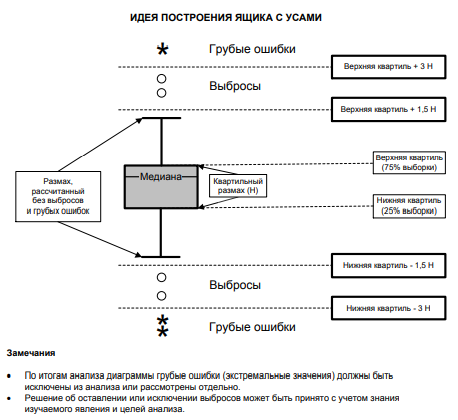

### Создание итоговой таблицы

Так как у нас задача регрессии, которая не требует работы с временными рядами, в финальную таблицу не будем добавлять данные из таблиц:
- data_bulk_time_new
- data_wire_time_new

Основой для таблиц объединения будут данные из таблицы data_temp_new.

In [64]:
data_total = data_temp_final_new

In [65]:
data_total = data_total.merge(data_arc_new[['key', 'Полная мощность', 'Эффективность мощности', 'Время нагрева']], left_on='key', right_on='key', how='inner')
data_total = data_total.merge(data_bulk_new, left_on='key', right_on='key', how='inner')
data_total = data_total.merge(data_gas_new, left_on='key', right_on='key', how='inner')
data_total = data_total.merge(data_wire_new, left_on='key', right_on='key', how='inner')

In [66]:
data_total = data_total.drop(['key'], axis=1)

In [67]:
data_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 2327
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Температура финального замера  2328 non-null   float64
 1   Температура первого замера     2328 non-null   float64
 2   Полная мощность                2328 non-null   float64
 3   Эффективность мощности         2328 non-null   float64
 4   Время нагрева                  2328 non-null   float64
 5   Bulk 1                         2328 non-null   float64
 6   Bulk 2                         2328 non-null   float64
 7   Bulk 3                         2328 non-null   float64
 8   Bulk 4                         2328 non-null   float64
 9   Bulk 5                         2328 non-null   float64
 10  Bulk 6                         2328 non-null   float64
 11  Bulk 7                         2328 non-null   float64
 12  Bulk 8                         2328 non-null   f

In [68]:
data_total = data_total.dropna()

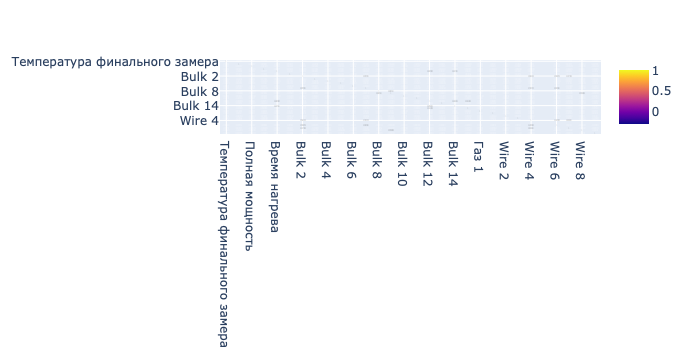

In [69]:
fig = px.imshow(data_total.corr(), text_auto=True, aspect="auto")
fig.show()

Исходя из тепловой карты можно увидеть только 1 сильную зависимость между значениями столбцов Bulk 9 и Wire 8.

In [70]:
anomaly_eda(data_total)

Количество аномалий: 39 значений | 1.675% значений


Несмотря на то что встречается свыше 20% аномалий в отдельных таблицах, если все данные объединить между собой, то количество аномалий составляет всего 1,6% данных. Для того что бы модель была более рабочей, обработка данных будет выполняться на обучающей выборке.

In [71]:
data_total = data_total.drop(['Wire 5'], axis=1)

# Обучение модели

Для задач регрессии будут применены модели:
- линейная регрессия
- случайный лес регрессии
- xgboost

## Разделение данных

Из условий задания необходимо:
- установить значение выборки 110923
- размер тестовой выборки 25%

In [72]:
data_total

Температура финального замера  Температура первого замера  \
0                            1613.0                      1571.0   
1                            1602.0                      1581.0   
2                            1599.0                      1596.0   
3                            1625.0                      1601.0   
4                            1602.0                      1576.0   
...                             ...                         ...   
2323                         1591.0                      1570.0   
2324                         1591.0                      1554.0   
2325                         1589.0                      1571.0   
2326                         1594.0                      1591.0   
2327                         1603.0                      1569.0   

      Полная мощность  Эффективность мощности  Время нагрева  Bulk 1  Bulk 2  \
0            0.743747                0.816686         1098.0     0.0     0.0   
1            0.647087                0.825276          811.0     0.0     0.0   
2            1.003845                0.809724          655.0     0.0     0.0   
3            0.850010                0.793923          741.0     0.0     0.0   
4            0.704245                0.796818          869.0     0.0     0.0   
...               ...                     ...            ...     ...     ...   
2323         0.967180                0.812727          723.0     0.0     0.0   
2324         0.845053                0.819606          940.0     0.0     0.0   
2325         1.453639                0.827613          569.0     0.0     0.0   
2326         0.781983                0.819245          750.0     0.0     0.0   
2327         0.542313                0.800782          883.0     0.0     0.0   

      Bulk 3  Bulk 4  Bulk 5  ...  Bulk 15      Газ 1      Wire 1    Wire 2  \
0        0.0    43.0     0.0  ...    154.0  29.749986   60.059998   0.00000   
1        0.0    73.0     0.0  ...    154.0  12.555561   96.052315   0.00000   
2        0.0    34.0     0.0  ...    153.0  28.554793   91.160157   0.00000   
3        0.0    81.0     0.0  ...    154.0  18.841219   89.063515   0.00000   
4        0.0    78.0     0.0  ...    152.0   5.413692   89.238236   9.11456   
...      ...     ...     ...  ...      ...        ...         ...       ...   
2323    21.0     0.0     0.0  ...    223.0   7.125735   89.150879   0.00000   
2324     0.0    63.0     0.0  ...    226.0   9.412616  114.179527   0.00000   
2325     0.0    85.0     0.0  ...    226.0   6.271699   94.086723   9.04800   
2326    90.0     0.0     0.0  ...    207.0  14.953657  118.110717   0.00000   
2327    47.0     0.0     0.0  ...    227.0  11.336151  110.160958  50.00528   

      Wire 3  Wire 4  Wire 6  Wire 7  Wire 8  Wire 9  
0        0.0     0.0     0.0     0.0     0.0     0.0  
1        0.0     0.0     0.0     0.0     0.0     0.0  
2        0.0     0.0     0.0     0.0     0.0     0.0  
3        0.0     0.0     0.0     0.0     0.0     0.0  
4        0.0     0.0     0.0     0.0     0.0     0.0  
...      ...     ...     ...     ...     ...     ...  
2323     0.0     0.0     0.0     0.0     0.0     0.0  
2324     0.0     0.0     0.0     0.0     0.0     0.0  
2325     0.0     0.0     0.0     0.0     0.0     0.0  
2326     0.0     0.0     0.0     0.0     0.0     0.0  
2327     0.0     0.0     0.0     0.0     0.0     0.0  

[2328 rows x 29 columns]

In [73]:
train_data, test_data = train_test_split(data_total, test_size=0.25, random_state=110923)

In [74]:
def data_clean_2(data):
    #функция замены грубых выбросов на пограничные данные
    for col in data.columns:
        Q1 = data[col].quantile(q=.25)
        Q3 = data[col].quantile(q=.75)
        IQR = Q3-Q1
        
        #поверка для замены нижних значений, что бы не ушли в минус
        if Q1-2.5*IQR <= 0:
            data.loc[data[col] < (Q1-2.5*IQR), col] = Q1
        elif Q1-2.5*IQR > 0:
            data.loc[data[col] < (Q1-2.5*IQR), col] = Q1
        
        #замена верхних границ
        data.loc[data[col] > (Q3+2.5*IQR), col] = Q3
        
    return data

In [75]:
train_data = data_clean_2(train_data)

In [76]:
X_train = train_data.drop('Температура финального замера', axis=1)
X_test = test_data.drop('Температура финального замера', axis=1)
y_train = train_data['Температура финального замера']
y_test = test_data['Температура финального замера']

In [77]:
pd.DataFrame({'Размер обучающей выборки':[len(X_train), f'{len(X_train)/len(data_total)*100:.1f}%'],
              'Размер тестовой выборки':[len(X_test), f'{len(X_test)/len(data_total)*100:.1f}%'],
              'Размер обучающей выборки целевого признака':[len(y_train), f'{len(y_train)/len(data_total)*100:.1f}%'],
              'Размер тестовой выборки целевого признака':[len(y_test), f'{len(y_test)/len(data_total)*100:.1f}%']
             }, index=['Количество', '% от общего']).T

Количество % от общего
Размер обучающей выборки                         1746       75.0%
Размер тестовой выборки                           582       25.0%
Размер обучающей выборки целевого признака       1746       75.0%
Размер тестовой выборки целевого признака         582       25.0%

Разбивка данных осуществленна корректно в соотношении 75% данных на обучение модели и 25% данных на проверку корректность работы модели.

In [78]:
scale = StandardScaler()
scale.fit(X_train)

StandardScaler()

## Обучение моделей

Задача будет считаться выполненной, при значении метрики MAE **менее** 6.8 по целевому признаку `Температура`.

### Модель линейной регрессии

In [79]:
model_lr = LinearRegression()

In [80]:
lr_scores = cross_val_score(model_lr, X_train, y_train, scoring='neg_mean_absolute_error', cv=200)
lr__mae = abs(lr_scores.mean())
lr__mae

6.406415555164833

In [81]:
print(f'Среднее абсолютное отклонение для модели Линейной регрессии составилo {lr__mae:.3f}')

Среднее абсолютное отклонение для модели Линейной регрессии составилo 6.406


Модель линейной регрессии простая и не содержит в себе какой-то набор гиперпараметров для оптимизации. Сама по себе модель не позволила выполнить задачу по оценке модели менее чем 6.8.

### Модель Случайного леса регрессии

In [82]:
def objective_cv(trial):
 
    # Список гиперпараметров для RandomForestRegressor
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 1, 251, step=10),
        'max_depth': trial.suggest_int('max_depth', 2, 50, step=6),
    }

    # модель машинного обучения
    model = RandomForestRegressor(**param, verbose=False, random_state=110923)

    # пайплайн
    pipeline = Pipeline(steps=[ ('scale', StandardScaler()),
                                ('model', model)])

    mae_rfr = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_absolute_error').mean()
    return mae_rfr

In [83]:
%%time
study_rfr = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_rfr.optimize(objective_cv, n_trials=30)

[I 2023-09-22 13:15:26,758] A new study created in memory with name: no-name-0bad507f-cbfe-4b9b-97c4-9d153f8cf8ec
[I 2023-09-22 13:15:30,258] Trial 0 finished with value: -6.4407073179348915 and parameters: {'n_estimators': 131, 'max_depth': 20}. Best is trial 0 with value: -6.4407073179348915.
[I 2023-09-22 13:15:36,156] Trial 1 finished with value: -6.41211645606406 and parameters: {'n_estimators': 231, 'max_depth': 38}. Best is trial 1 with value: -6.41211645606406.
[I 2023-09-22 13:15:36,446] Trial 2 finished with value: -6.724325652668178 and parameters: {'n_estimators': 11, 'max_depth': 20}. Best is trial 1 with value: -6.41211645606406.
[I 2023-09-22 13:15:36,781] Trial 3 finished with value: -6.950992689671237 and parameters: {'n_estimators': 51, 'max_depth': 2}. Best is trial 1 with value: -6.41211645606406.
[I 2023-09-22 13:15:37,866] Trial 4 finished with value: -6.424176761195108 and parameters: {'n_estimators': 61, 'max_depth': 8}. Best is trial 1 with value: -6.4121164560

CPU times: user 1min 46s, sys: 690 ms, total: 1min 47s
Wall time: 6min 44s


In [84]:
mae_rfr = abs(study_rfr.best_value)
best_param_rfr = study_rfr.best_params

In [85]:
print(f'Среднее абсолютное отклонение для модели Случайного леса регрессии составилo {mae_rfr:.3f}')

Среднее абсолютное отклонение для модели Случайного леса регрессии составилo 6.393


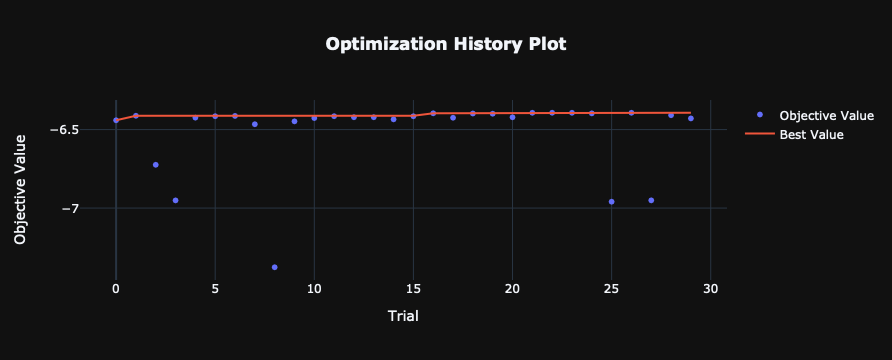

In [86]:
fig = optuna.visualization.plot_optimization_history(study_rfr)
fig.update_layout(template='plotly_dark', title='<b>Optimization History Plot', title_x=0.5)

### Модель CatBoost

In [87]:
def objective_cbr(trial):    
    # Список гиперпараметров для перебора (для CatBoostClassifier)
    param = {
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 16, step=2),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "n_estimators": trial.suggest_int("n_estimators", 10, 500, step=10),
        "learning_rate": trial.suggest_float("learning_rate", 0.002, 1, step=0.003)
            }
    

    model = CatBoostRegressor(**param, verbose=False, random_state=110923)


    pipeline = Pipeline(steps=[('scale', StandardScaler()),
                               ('model', model)
                               ])

    mae_cbr = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_absolute_error').mean()
    return mae_cbr


In [88]:
%%time
study_cbr = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_cbr.optimize(objective_cbr, n_trials=150)

[I 2023-09-22 13:22:11,305] A new study created in memory with name: no-name-5ff8fb98-ac24-4dc5-ace2-dafe8b8ec46f
[I 2023-09-22 13:22:11,582] Trial 0 finished with value: -6.518948096182163 and parameters: {'colsample_bylevel': 0.09257043364147158, 'depth': 7, 'boosting_type': 'Ordered', 'n_estimators': 100, 'learning_rate': 0.509}. Best is trial 0 with value: -6.518948096182163.
[I 2023-09-22 13:22:11,731] Trial 1 finished with value: -6.366042616508129 and parameters: {'colsample_bylevel': 0.09857195484568239, 'depth': 3, 'boosting_type': 'Plain', 'n_estimators': 250, 'learning_rate': 0.20600000000000002}. Best is trial 1 with value: -6.366042616508129.
[I 2023-09-22 13:22:11,860] Trial 2 finished with value: -6.59818248860324 and parameters: {'colsample_bylevel': 0.03698274081515834, 'depth': 3, 'boosting_type': 'Ordered', 'n_estimators': 140, 'learning_rate': 0.926}. Best is trial 1 with value: -6.366042616508129.
[I 2023-09-22 13:22:11,963] Trial 3 finished with value: -6.66274475

CPU times: user 1min 45s, sys: 1min 34s, total: 3min 20s
Wall time: 6min 5s


In [89]:
mae_cbr = abs(study_cbr.best_value)
best_param_cbr = study_cbr.best_params
mae_cbr

6.293107792608269

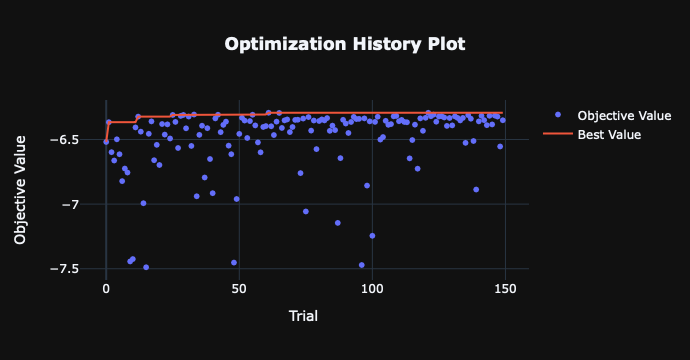

In [90]:
fig = optuna.visualization.plot_optimization_history(study_cbr)
fig.update_layout(template='plotly_dark', title='<b>Optimization History Plot', title_x=0.5)

### Выводы по обученным моделям

In [91]:
pd.set_option('max_colwidth', 150)
pd.DataFrame({'Линейная регрессия':[f'{lr__mae:.3f}', 'Нет гипер-параметров'],
              'Случайный лес регрессии':[f'{mae_rfr:.3f}', f'{best_param_rfr}'],
              'CatBoost':[f'{mae_cbr:.3f}', f'{best_param_cbr}']
             }, index=['Оценка MAE', 'Наилучшие гипер-параметры']).T

Оценка MAE  \
Линейная регрессия           6.406   
Случайный лес регрессии      6.393   
CatBoost                     6.293   

                                                                                                                             Наилучшие гипер-параметры  
Линейная регрессия                                                                                                                Нет гипер-параметров  
Случайный лес регрессии                                                                                          {'n_estimators': 221, 'max_depth': 8}  
CatBoost                 {'colsample_bylevel': 0.0915014762954166, 'depth': 7, 'boosting_type': 'Ordered', 'n_estimators': 340, 'learning_rate': 0.08}

## Применение лучшей модели

В соответствии с пунктом 7.2.4 наилучшей моделью можно признать модель CatBoost, но отличия по метрике были не значительны, для эксперимента применим все 3 модели к тестовой выборке дополнительно.

### catBoostRegressor

In [92]:
model = CatBoostRegressor(**best_param_cbr, verbose=False, random_state=110923)
model.fit(X_train, y_train)
predict = model.predict(X_test)
mae_final = mean_absolute_error(y_test, predict)
mae_final

6.609076803202497

### Вывод по разделу

В итоговой таблице представлены значения обученных моделей в процессе решения задачи

Не тестовой выборке значения чуть хуже, чем на тренировочной, что говорит об отсутствии переобучения моделей. Финальная метрика всех трех моделей достигла результата лучше, чем заявлена заказчиком 6.8.
На мой взгляд, поставленная задача выполнена в полном объеме.

## Анализ важности фичей

In [93]:
model = CatBoostRegressor(**best_param_cbr, verbose=False)

In [94]:
model.fit(X_train, y_train);

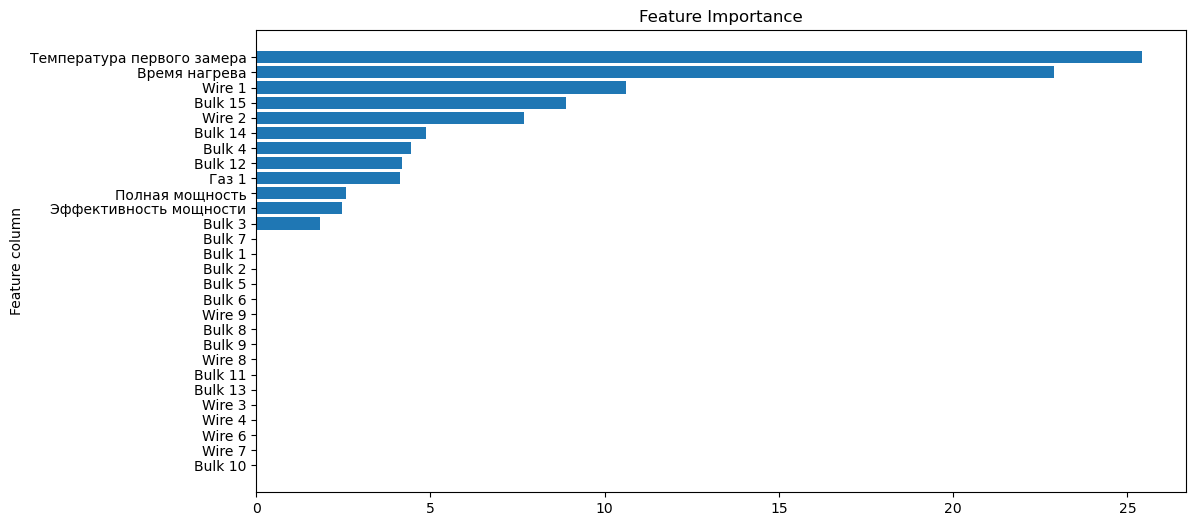

In [95]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.ylabel('Feature column')
plt.show()

In [96]:
feature_data = list(zip(data_total.columns, model.feature_importances_))
feature_df = pd.DataFrame(feature_data, columns =['Feature', 'Importance']).sort_values('Importance', ascending=False)
feature_df

Feature  Importance
0   Температура финального замера   25.415371
3          Эффективность мощности   22.885589
20                          Газ 1   10.611964
18                        Bulk 14    8.886199
21                         Wire 1    7.692306
17                        Bulk 13    4.872304
7                          Bulk 3    4.441798
15                        Bulk 11    4.173701
19                        Bulk 15    4.124413
1      Температура первого замера    2.590350
2                 Полная мощность    2.461543
6                          Bulk 2    1.844461
26                         Wire 7    0.000000
25                         Wire 6    0.000000
23                         Wire 3    0.000000
22                         Wire 2    0.000000
24                         Wire 4    0.000000
14                        Bulk 10    0.000000
16                        Bulk 12    0.000000
13                         Bulk 9    0.000000
12                         Bulk 8    0.000000
11                         Bulk 7    0.000000
10                         Bulk 6    0.000000
9                          Bulk 5    0.000000
8                          Bulk 4    0.000000
5                          Bulk 1    0.000000
4                   Время нагрева    0.000000
27                         Wire 8    0.000000

Таблица вляиния фичей на обучение модели

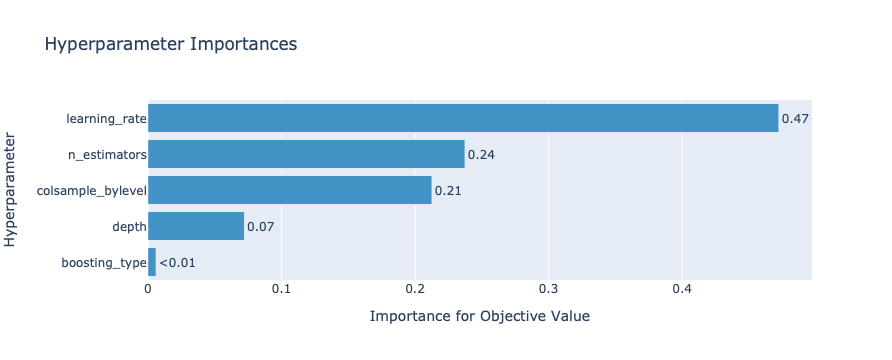

In [97]:
fig = optuna.visualization.plot_param_importances(study_cbr)
fig.show()

<!-- Наибольшое влияние имеют столбцы (в порядке убывания):
- Wire 1
- Bulk 12
- Bulk 15
- Wire 2
- Bulk 14
- Газ 1
- Bulk 4
- S/t
- Полная мощность
- Время нагрева -->

## Доп проверка модели

In [98]:
feature_df = feature_df.loc[feature_df['Feature'] != 'Температура финального замера']
X_train_2 = X_train[feature_df.loc[feature_df['Importance'] > 0, 'Feature']]
X_test_2 = X_test[feature_df.loc[feature_df['Importance'] > 0, 'Feature']]

In [99]:
model = CatBoostRegressor(**best_param_cbr, verbose=False, random_state=110923)
model.fit(X_train_2, y_train)
predict = model.predict(X_test_2)
mae_final = mean_absolute_error(y_test, predict)
mae_final

7.501340961172772

Несмотря на исключение некоторых фичей, которые изначально не влияют на обученную модель, переобучение модели с исключением фичей привело к значительному спаду целевой метрики.

# Отчет

Целью работы является создание модели машинного обучения для оптимизации затрат на электричество для поддержания необходимой температуры сплава металла при технологическом процессе.

Условием задания было достигнуть метрики оценки отклоения Mean Absolute Error (MAE) менее 6.8.

## Ответы на вопросы задания

### Выполненные пункты плана

От заказчика получены данные:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер производственной партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным этапам технологического процесса.

Целевым признаком обучения модели является конечная температура сплава. Эти данные есть в файле `data_temp_new`, ей является последняя запись температуры конкретного ключа партии.

### Трудности в решении задачи

В ходе решения задачи были выявлены:
- выбросы значений
- некорректные значения, как пример, в целевой переменной для предсказания содержались:
    - пропуски данных
    - отрицательные значения температуры
    - температура не соответствующей требованиям технологического процесса

### Ключевые шаги по решению задачи

В ходе решения задачи были выполнены следующие действия.

Данные `data_arc_new`:

- Удалены выбросы (партии с отрицательной мощностью).

- Для данных о времени изменен тип и найдена `Время нагрева` электродами. Эти данные использовались как новый признак.

- Созданы новые признаки: `Полная мощность` и `Эффективность мощности`.

- Удалены мультиколлениарные признаки `Активная мощность` и `Реактивная мощность`, 

- Исключен признак `Конец нагрева дугой`.

- Данные сгруппированы по партиям для создания признаков:

    - `Полная мощность` и `Эффективность мощности` - среднее значение для партии,
    
    - `Длительнось` - суммарное время для партии.

Датасеты `data_bulk_new` и `data_wire_new`:

- Пропуски заполнены нулями так как отсутствие значение подразумевает отсутствие добавления материала.

Датасеты `data_bulk_time_new` и `data_wire_time_new`:

- Работа с этими данными не выполнялась и не применялись в модели машинного обучения.

Датасет `data_gas_new`:

- Обработка данных не требовалось.

Датасет `data_temp_new`:

- Пропуски в значениях заменены заглушкой - температурой, которая невозможна в расплавленном металле (-9999).

- Данные сгруппированы по ключу и данным температуры, найдены значения конечных температур каждой партии. Составлен список партий, где значение конечной температуры было равно заглушке. Такие данные были удалены.

- Удалены данные, для которых была зафиксирована конечная температура ниже 1500 градусов.

Датасет `data_total`:

- Из итоговых значений предыдущих таблиц была собрана общая таблица признаков и целевого значения. Данные объединялись по значению столбца `key`, в финальную таблицу отбирались только те значения, которые присутствовали в итоговой таблице `data_temp_new`. В итоговой таблице 2328 строк и 29 столбцов.

- Итоговый датасет разбит на учебную выборку и тестовую выборку в соотношении 75%-25%.

- В целях оптимизации обучения, на тренировочной выборке были "сглажены" грубые выбросы.

- Для сохранения возможности модели работать с реальными данными, тестовая выборка данных не подвергалась никакой дополнительной обработке.

### Итоговая модель

В процессе подбора модели были испытаны 3 модели:
- Линейная Регрессия
- Случаный Лес Регрессия
- Модель градиентного бустинга CatBoostRegressor

Модель Линейной регрессии показала результат MAE `6.406`

Моель Случайного Леса Регрессии показала результат MAE `6.408`

Модель CatBoostRegressor показала результат MAE `6.296`

К тестовому набору данных была применена модели CatBoostRegressor и показала результат `6.65`, что соответствует условиям задачи. Дополнительно следует отметить, что модель CatBoostRegressor имела сравнительно малым временем обучения, что позволяет ее оперативно переобучать при необходимости.

## Признаки модели

Основными признаками, влияющими на модель:

- Температура финального замера	- 26.89%
- Эффективность мощности - 24.98%
- Газ 1	- 11.32%
- Wire 1 - 10.60%
- Bulk 14 - 6.54%
- Bulk 15 - 5.08%
- Bulk 3 - 4.37%
- Bulk 11 - 2.65%
- Bulk 2 - 2.06%
- Температура первого замера - 1.96%
- Полная мощность - 1.95%
- Bulk 13 - 1.55%

Несмотря на то что отсальные признаки имеют нулевой вес на модель, их исключение приводит к снижению целевой метрики до `7.61`.

## Гиперпараметры модели

Подбор гиперпараметров был осуществлен с помощью библиотеки Optuna.

Были подобрабны следующие гиперпараметры:
- colsample_bylevel: 0.07960817748205745
- depth: 15
- boosting_type: Plain
- n_estimators: 460 
- learning_rate: 0.107

## Рекомендации по улучшению

Рекомендации по улучшениям:
- наладить сбор данных с измерительного оборудования
- дополнитель модель признаком по нарушению параметров технологического процесса (в момент когда появляются выбросы, это фиксируется как факт нарушения)